# Segmenting tags more effectively
- Trying to work out how to reduce the number of tags I try to classify which are at an angle
- Trying to update tag segmentation technique

## Outcome
- Ended up finding out that fitting an ellipse worked best
- I tried to set a min area for the contour and have tag width/height be above 26 but found that for some tags in videos this excluded too many.
- The best result is to have width and height > 23

In [1]:
%matplotlib inline
#from pylab import rcParams
#rcParams['figure.figsize'] = 12, 8

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas

Software versions
Python 2.7.13 64bit [GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
IPython 5.3.0
OS Darwin 16.5.0 x86_64 i386 64bit
numpy 1.12.1
scipy 0.19.0
matplotlib 2.0.1
pandas 0.19.2
Thu May 04 11:38:53 2017 AEST

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import cv2

import os
import sys

sys.path.append("../src")
from images_permute import processing_pipeline

np.random.seed(0)

def view(image):
    plt.figure()
    plt.axis('off')
    plt.imshow(image, cmap = cm.Greys_r)

(2178, 3840, 3)


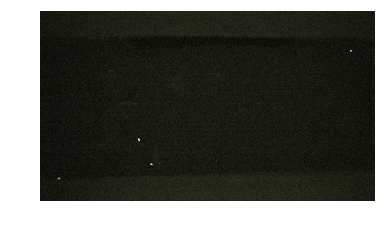

In [10]:
image = cv2.imread('/Users/jacksimpson/Data/beeunique/vlcsnap-2017-05-04-11h37m19s033.png', cv2.IMREAD_COLOR)
print(image.shape)
view(image)

In [30]:
def segment_frame(frame):
    rect_dims = 14
    frame_height, frame_width, frame_dims = frame.shape
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smoothed_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    grad_x = cv2.Sobel(smoothed_frame, cv2.CV_16S, 1, 0, ksize=3, scale=1.5, delta=0, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(smoothed_frame, cv2.CV_16S, 0, 1, ksize=3, scale=1.5, delta=0, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    scharr = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    ret, thresh = cv2.threshold(scharr, 70, 255, 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(13, 13))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    tag_locs = []
    tag_images = []
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) > 100:
            centre, width_height, rotation = cv2.minAreaRect(cnt)
            #tag_locs.append({'x': centre[0], 'y': centre[1], 'frame_num': frame_num, 'classified': 0})
            if width_height[0] > 27 and abs(width_height[0] - width_height[1]) < 4 and width_height[0] < 100 and centre[0] - rect_dims > 0 and centre[0] + rect_dims < frame_width and centre[1] - rect_dims > 0 and centre[1] + rect_dims < frame_height:
                extracted_tag_matrix = gray_frame[int(centre[1])-rect_dims:int(centre[1])+rect_dims, int(centre[0])-rect_dims:int(centre[0])+rect_dims]
                tag_images.append(extracted_tag_matrix)
                print('right size', cv2.contourArea(cnt), width_height, abs(width_height[0] - width_height[1]))
            else:
                extracted_tag_matrix = gray_frame[int(centre[1])-rect_dims:int(centre[1])+rect_dims, int(centre[0])-rect_dims:int(centre[0])+rect_dims]
                tag_images.append(extracted_tag_matrix)
                print('wrong size', cv2.contourArea(cnt), width_height, abs(width_height[0] - width_height[1]))
                
    return tag_images

('wrong size', 784.5, (27.906131744384766, 36.0454216003418), 8.139289855957031)
('wrong size', 727.0, (33.0, 28.0), 5.0)
('right size', 1024.0, (34.0, 37.0), 3.0)
('wrong size', 654.5, (33.98823165893555, 25.043960571289062), 8.944271087646484)
4


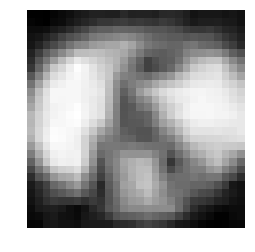

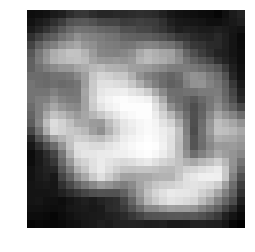

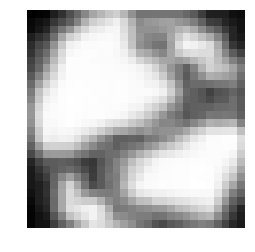

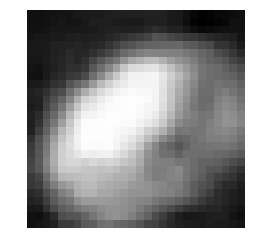

In [31]:
tag_images = segment_frame(image)
print(len(tag_images))
for im in tag_images:
    if im is not None:
        view(im)

## Fit Bounding rect without rotation

In [64]:
def segment_frame(frame):
    rect_dims = 14
    frame_height, frame_width, frame_dims = frame.shape
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smoothed_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    grad_x = cv2.Sobel(smoothed_frame, cv2.CV_16S, 1, 0, ksize=3, scale=1.5, delta=0, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(smoothed_frame, cv2.CV_16S, 0, 1, ksize=3, scale=1.5, delta=0, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    scharr = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    ret, thresh = cv2.threshold(scharr, 70, 255, 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(13, 13))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    tag_locs = []
    tag_images = []
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        contour_area = cv2.contourArea(cnt)
        if contour_area > 100:
            x,y,w,h = cv2.boundingRect(cnt)
            centre = x+w/2, y + h/2
            print(w,h, abs(w-h), contour_area)
            extracted_tag_matrix = gray_frame[int(y):int(y)+h, int(x):int(x)+w]
            view(extracted_tag_matrix)
            cropped_extracted_tag_matrix = gray_frame[int(centre[1])-rect_dims:int(centre[1])+rect_dims, int(centre[0])-rect_dims:int(centre[0])+rect_dims]
            view(cropped_extracted_tag_matrix)
            
            

#cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

(37, 29, 8, 784.5)
(34, 29, 5, 727.0)
(35, 38, 3, 1024.0)
(33, 28, 5, 654.5)


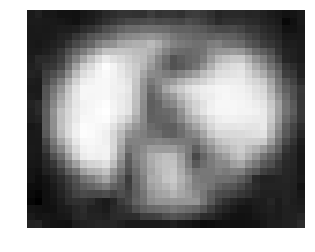

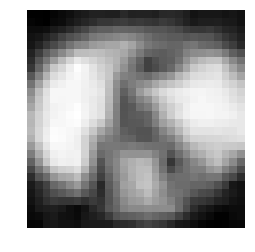

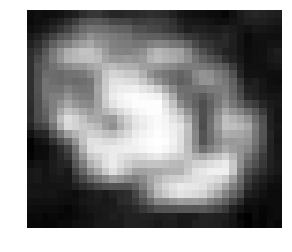

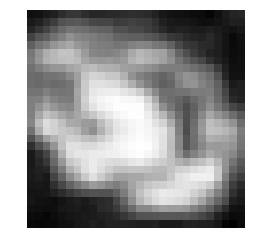

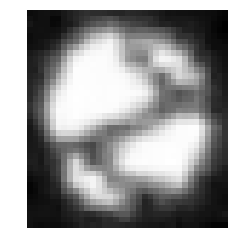

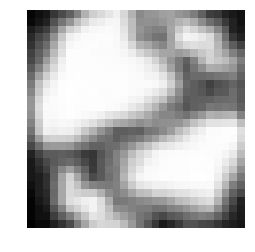

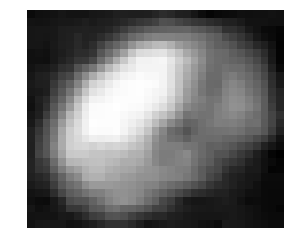

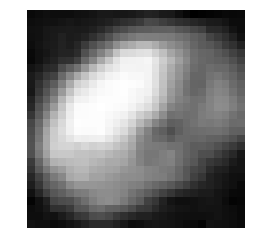

In [65]:
segment_frame(image)

## Other test with min rect

In [50]:
def segment_frame(frame):
    rect_dims = 14
    frame_height, frame_width, frame_dims = frame.shape
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smoothed_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    grad_x = cv2.Sobel(smoothed_frame, cv2.CV_16S, 1, 0, ksize=3, scale=1.5, delta=0, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(smoothed_frame, cv2.CV_16S, 0, 1, ksize=3, scale=1.5, delta=0, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    scharr = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    ret, thresh = cv2.threshold(scharr, 70, 255, 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(13, 13))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    tag_locs = []
    tag_images = []
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) > 100:
            centre, width_height, rotation = cv2.minAreaRect(cnt)
            #extracted_tag_matrix = gray_frame[int(centre[1])-rect_dims:int(centre[1])+rect_dims, int(centre[0])-rect_dims:int(centre[0])+rect_dims]
            extracted_tag_matrix = gray_frame[int(centre[1])-int(width_height[1]):int(centre[1])+int(width_height[1]), int(centre[0])-int(width_height[0]):int(centre[0])+int(width_height[0])]
            view(extracted_tag_matrix)
            print('right size', cv2.contourArea(cnt), width_height, abs(width_height[0] - width_height[1]))

('right size', 784.5, (27.906131744384766, 36.0454216003418), 8.139289855957031)
('right size', 727.0, (33.0, 28.0), 5.0)
('right size', 1024.0, (34.0, 37.0), 3.0)
('right size', 654.5, (33.98823165893555, 25.043960571289062), 8.944271087646484)


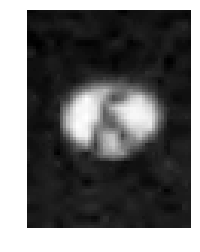

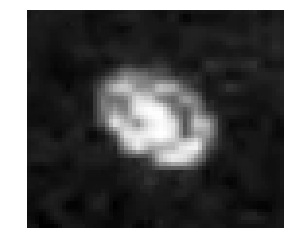

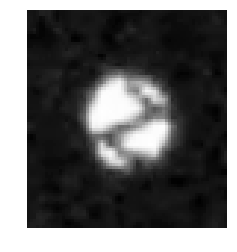

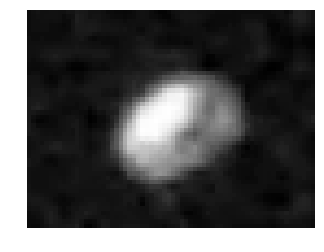

In [51]:
segment_frame(image)

## Fit Ellipse

In [91]:
def segment_frame(frame):
    rect_dims = 14
    frame_height, frame_width, frame_dims = frame.shape
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smoothed_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    grad_x = cv2.Sobel(smoothed_frame, cv2.CV_16S, 1, 0, ksize=3, scale=1.5, delta=0, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(smoothed_frame, cv2.CV_16S, 0, 1, ksize=3, scale=1.5, delta=0, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    scharr = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    ret, thresh = cv2.threshold(scharr, 70, 255, 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(13, 13))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    tag_locs = []
    tag_images = []
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        contour_area = cv2.contourArea(cnt)
        if contour_area > 100:
            #x,y,w,h = cv2.boundingRect(cnt)
            centre, width_height, angle = cv2.fitEllipse(cnt)
            print(width_height, contour_area)
            cropped_extracted_tag_matrix = gray_frame[int(centre[1])-rect_dims:int(centre[1])+rect_dims, int(centre[0])-rect_dims:int(centre[0])+rect_dims]
            view(cropped_extracted_tag_matrix)

((27.938037872314453, 37.04808807373047), 89.50401306152344)
((26.204458236694336, 37.0019416809082), 117.62454986572266)
((35.198875427246094, 37.86760330200195), 162.3070526123047)
((24.975038528442383, 33.719234466552734), 63.934654235839844)


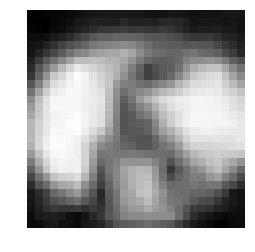

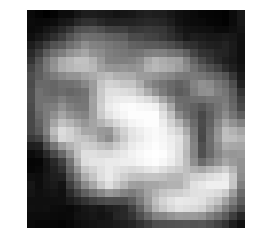

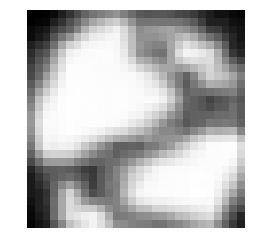

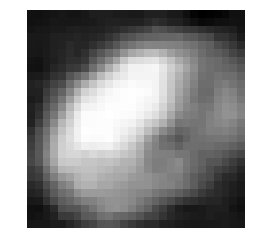

In [79]:
segment_frame(image)

## Test image with N, Necklace and scissors in it

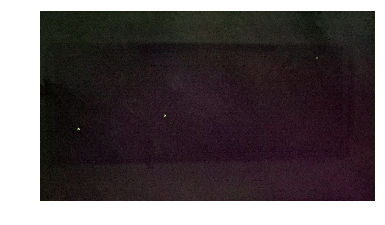

In [84]:
image2 = cv2.imread('/Users/jacksimpson/Data/beeunique/vlcsnap-2017-05-04-22h41m36s096.png', cv2.IMREAD_COLOR)
view(image2)

((32.320274353027344, 33.42813491821289), 827.0)
((29.297943115234375, 34.56172180175781), 761.5)
((24.809629440307617, 28.797212600708008), 527.0)


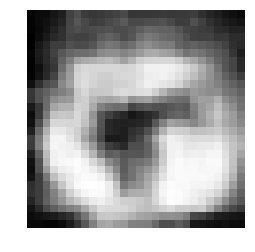

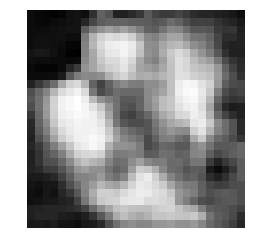

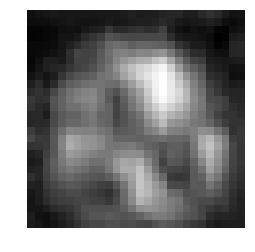

In [92]:
segment_frame(image2)